## Two-mode squeezing with stability inset

In [1]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt


#Function to determine the two-mode squeezing with coherent unidirectional feedback connecting the two sides
def Squeez(eps,theta,Del,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nu):
	kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
	kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
	kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
	kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)
	ka = 2*sqrt(ra*(1-ra)*(1-La/100.))*kapa    #k_a (feedback strength in mode a)
	kb = 2*sqrt(rb*(1-rb)*(1-Lb/100.))*kapb    #k_b (feedback strength in mode b)
	ta    = kta/kapa                           #\tau_a (time delay in mode a)
	tb    = ktb/kapb                           #\tau_b (time delay in mode b)
	N    = int(len(nu))                           #\tau_b (time delay in mode b)

	### EXPRESSIONS ###
	Ema = np.exp(1j*(-nu*ta+phia))
	Emb = np.exp(1j*(-nu*tb+phib))
	Epa = np.exp(1j*(nu*ta+phia))
	Epb = np.exp(1j*(nu*tb+phib))
	dma = kapa-1j*(nu-Del) + ka*Epa         #d_{-,a}(\nu)
	dmb = kapb-1j*(nu+Del) + kb*Epb         #d_{-,b}(\nu)
	dpa = kapa-1j*(nu+Del) + ka*conj(Ema)   #d_{+,a}(\nu)
	dpb = kapb-1j*(nu-Del) + kb*conj(Emb)   #d_{+,b}(\nu)
	Lab = abs(eps)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
	Lba = abs(eps)**2 - dpb*dma          #\Lambda_{ba}(\nu)

	alpha1p = sqrt(2*kap1a)+sqrt(2*kap2a*(1-La/100.))*Epa   #\alpha_1(\nu)
	alpha2p = sqrt(2*kap2a)+sqrt(2*kap1a*(1-La/100.))*Epa   #\alpha_2(\nu)
	beta1p  = sqrt(2*kap1b)+sqrt(2*kap2b*(1-Lb/100.))*Epb   #\beta_1(\nu)
	beta2p  = sqrt(2*kap2b)+sqrt(2*kap1b*(1-Lb/100.))*Epb   #\beta_2(\nu)
	alpha1m = sqrt(2*kap1a)+sqrt(2*kap2a*(1-La/100.))*Ema   #\alpha_1(-\nu)
	alpha2m = sqrt(2*kap2a)+sqrt(2*kap1a*(1-La/100.))*Ema   #\alpha_2(-\nu)
	beta1m  = sqrt(2*kap1b)+sqrt(2*kap2b*(1-Lb/100.))*Emb   #\beta_1(-\nu)
	beta2m  = sqrt(2*kap2b)+sqrt(2*kap1b*(1-Lb/100.))*Emb   #\beta_2(-\nu)

	Da  = sqrt(1-La/100.)*Lba*Epa+dpb*alpha1p*alpha2p
	Db  = sqrt(1-Lb/100.)*Lab*Epb+dpa*beta1p*beta2p
	Ea  = sqrt(La/100.)*(sqrt(2*kap2a)*dpb*alpha2p+Lba)
	Eb  = sqrt(Lb/100.)*(sqrt(2*kap2b)*dpa*beta2p+Lab)
	Mba = exp(1j*(theta-(thetapa+thetapb)/2))*alpha2m*(Db*np.conj(beta1p)+sqrt(2*Lb/100.*kap2b)*Eb)
	Mab = exp(1j*(theta-(thetapa+thetapb)/2))*beta2m*(Da*np.conj(alpha1p)+sqrt(2*La/100.*kap2a)*Ea)
	Nba = abs(eps)*(np.abs(alpha2m)**2*(np.abs(beta1p)**2+2*Lb/100.*kap2b)+\
	np.abs(beta2p)**2*(np.abs(alpha1m)**2+2*La/100.*kap2a))
	Nab = abs(eps)*(np.abs(beta2m)**2*(np.abs(alpha1p)**2+2*La/100.*kap2a)+\
	np.abs(alpha2p)**2*(np.abs(beta1m)**2+2*Lb/100.*kap2b))
	### CORRELATIONS ###
	ncorrm = abs(eps)*(1/np.abs(Lab)**2*(2*np.real(Mba)+Nba))  #(normalized)
	ncorrp = abs(eps)*(1/np.abs(Lba)**2*(2*np.real(Mab)+Nab))   #(normalized)
#	Soutm  = 10*np.log10(1.+ncorrm)
#	Soutp  = 10*np.log10(1.+ncorrp)
	Sout   = np.zeros(N)
	Sout[0:int(N/2)]  = 10*np.log10(1.+ncorrm[0:int(N/2)])
	Sout[int(N/2):N]  = 10*np.log10(1.+ncorrp[int(N/2):N])
	return Sout#,Soutm,Soutp



In [5]:
%matplotlib inline

from pylab import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

#Function to plot the two-mode squeezing with and without feedback as well as the stability of the system with feedback
def stab_squeez_slider(x,theta,dela,loss,kapa,ra,kta,phia,kapb,rb,ktb,phib,nui,nuf,N):
	### PARAMETERS ####
	La=0
	Lb=0    
	thetapa=0
	thetapb=0
	#Most of the parameters are given without the constant pi or 2pi.
	kapa = kapa*2.*pi       #\kappa_a (overall coupling for mode a)
	kapb = kapb*2.*pi       #\kappa_b (overall coupling for mode b)
	theta = theta*pi        #\theta (coherent pump phase)
	thetapa = thetapa*pi    #\theta^\prime_a (local oscillator phase for mode a)
	thetapb = thetapb*pi    #\theta^\prime_b (local oscillator phase for mode b)
	phia = phia*pi          #\phi_a (overall phase shift for mode a)
	phib = phib*pi          #\phi_b (overall phase shift for mode b)
	N = N*1000 +1           #resolution of frequencies

	#Parameters calculated from the input parameters
	eps   = x*kapa*exp(1j*theta)                #\epsilon (the coherent pump amplitude)
	Del   = kapa*dela                           #\Delta (detuning of modes a, same as for b but in the opposite direction)
	ta    = kta/kapa                           #\tau_a (time delay in mode a)
	tb    = ktb/kapb                           #\tau_b (time delay in mode b)
	kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
	kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
	kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
	kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)
    
	#Frequency range initialization (nui:min, nuf:max, N:number of points)
	nu = linspace(nui*2.*pi,nuf*2.*pi,N)
    
        
	Sout_fb  = Squeez(eps,theta,Del,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nu)    
#	Soutp_th  = 10*np.log10(1+4*eps*kap1a/((eps-kapa)**2+(nu-Del)**2))    
#	Soutm_th  = 10*np.log10(1.+4*eps*kap1a/((eps-kapa)**2+(nu+Del)**2))
	Sout_th  = np.zeros(N)
	Sout_th[int(N/2):N]  = 10*np.log10(1+4*eps*kap1a/((eps-kapa)**2+(nu[int(N/2):N]-Del)**2))    
	Sout_th[0:int(N/2)]  = 10*np.log10(1.+4*eps*kap1a/((eps-kapa)**2+(nu[0:int(N/2)]+Del)**2))
#	Soutp_th1 = 10*np.log10(1+4*eps*kapa/((eps-kapa)**2+(nu-Del)**2))
#	Soutm_th1 = 10*np.log10(1+4*eps*kapa/((eps-kapa)**2+(nu+Del)**2))    
	Sout_th1 = np.zeros(N)
	Sout_th1[int(N/2):N] = 10*np.log10(1+4*eps*kapa/((eps-kapa)**2+(nu[int(N/2):N]-Del)**2))
	Sout_th1[0:int(N/2)] = 10*np.log10(1+4*eps*kapa/((eps-kapa)**2+(nu[0:int(N/2)]+Del)**2))    
    
	## STABILITY ##    
	ka    = 2*sqrt(ra*(1-ra)*(1-La/100.))*kapa    #k_a (feedback strength in mode a)
	kb    = 2*sqrt(rb*(1-rb)*(1-Lb/100.))*kapb    #k_b (feedback strength in mode b)
    
	## Functions ##
	def Ra(lambr,lambi):
		return lambr+1j*lambi*2*pi+kapa+ka*cos(phia)*exp(-(1j*2*np.pi*lambi+lambr)*ta)
	def Ia(lambr,lambi):
		return Del+ka*sin(phia)*exp(-(1j*2*np.pi*lambi+lambr)*ta)
	def Rb(lambr,lambi):
		return lambr+1j*lambi*2*pi+kapb+kb*cos(phib)*exp(-(1j*2*np.pi*lambi+lambr)*tb)
	def Ib(lambr,lambi):
		return Del-kb*sin(phib)*exp(-(1j*2*np.pi*lambi+lambr)*tb)
    
	## Equations ##
	def eq1(lambr, lambi):
		return (Ra(lambr,lambi)+1j*Ia(lambr,lambi))*(Rb(lambr,lambi)+1j*Ib(lambr,lambi)) - eps**2
	def equation1(l):
		equations = [np.real(eq1(l[0],l[1]))]
		equations.append(np.imag(eq1(l[0],l[1])))
		return equations
	def eq2(lambr, lambi):
		return (Ra(lambr,lambi)-1j*Ia(lambr,lambi))*(Rb(lambr,lambi)-1j*Ib(lambr,lambi)) - eps**2
	def equation2(l):
		equations = [np.real(eq2(l[0],l[1]))]
		equations.append(np.imag(eq2(l[0],l[1])))
		return equations
	
	## Grid ##
	lr = np.linspace(-20,20,400)
	li = np.linspace(-60,60,400)
	lr,li = np.meshgrid(lr,li)

	## Solving the stability equations ##
	lamb1 = np.zeros(2)
	lamb2 = np.zeros(2)
	lamb1 = fsolve(equation1,[10,5])
	lamb2 = fsolve(equation2,[10,5])
	lambr = np.array([lamb1[0],lamb1[0],lamb2[0],lamb2[0]])
	lambi = np.array([lamb1[1],-lamb1[1],lamb2[1],-lamb2[1]])    
    
	## Figures ##
    
	### Linestyles ###
	colors={'red':(241/255.,88/255.,84/255.),\
	        'orange':(250/255,164/255.,58/255.),\
	        'pink':(241/255,124/255.,176/255.),\
	        'brown':(178/255,145/255.,47/255.),\
	        'purple':(178/255,118/255.,178/255.),\
	        'green':(96/255,189/255.,104/255.),\
	        'blue':(93/255,165/255.,218/255.),\
	        'yellow':(222/255., 207/255., 63/255),\
	        'black':(0.,0.,0.)}
	collab = ['brown','green','blue','pink','black']
	linewidth = [2,2,3,3,4]
	linestyle = ['solid','dashed','dashdot','dotted','solid']

	### Squeezing spectrum ###
	fsfont = {'fontname':'FreeSerif'}
	fig=plt.figure(figsize=(12,8))
	axsq = fig.add_axes([.15,.15,.8,.8]) # main axes
	axsq.set_xlabel('$\\nu/(2\pi)$ (MHz)',fontsize = 40,**fsfont)
	axsq.set_ylabel('$S_{out,\\theta^\\prime} (\\nu)$ (dB)',fontsize = 40,**fsfont)
	axsq.set_ylim(-25,2)
	axsq.xaxis.set_label_coords(0.5, -0.10)
	axsq.yaxis.set_label_coords(-0.10,0.5)
	plt.xticks(fontsize = 35,**fsfont)
	plt.yticks(fontsize = 35,**fsfont)
#	axsq.plot(nu/2/pi,np.real(Soutm_fb),color = colors["brown"],linewidth = 3,linestyle="solid")
	axsq.plot(nu/2/pi,np.real(Sout_fb),color = colors["red"],linewidth = 3,linestyle="solid")
	axsq.grid(True)
#	axsq.plot(nu/2/pi,np.real(Soutp_fb),color = colors["brown"],linewidth = 3,linestyle="solid")
	Sout_fbL = Squeez(eps,theta,Del,kapa,ra,kta,phia,La+loss,thetapa,kapb,rb,ktb,phib,Lb+loss,thetapb,nu)    
	axsq.plot(nu/2/pi,np.real(Sout_fbL),color = colors["yellow"],linewidth = 5,linestyle="dashed")
#	axsq.plot(nu/2/pi,np.real(Soutm_fbL),color = colors["green"],linewidth = 4,linestyle="dashdot")
#	axsq.plot(nu/2/pi,np.real(Soutp_fbL),color = colors["green"],linewidth = 4,linestyle="dashdot")
	axsq.plot(nu/2/pi,np.real(Sout_th),color = colors["green"],linewidth = 6,linestyle="dotted")
#	axsq.plot(nu/2/pi,np.real(Soutm_th),color = colors["yellow"],linewidth = 6,linestyle="dotted")
#	axsq.plot(nu/2/pi,np.real(Soutp_th),color = colors["yellow"],linewidth = 6,linestyle="dotted")
	axsq.plot(nu/2/pi,np.real(Sout_th1),color = colors["blue"],linewidth = 4,linestyle="dashdot")
#	axsq.plot(nu/2/pi,np.real(Soutm_th1),color = colors["blue"],linewidth = 3,linestyle="dashed")
#	axsq.plot(nu/2/pi,np.real(Soutp_th1),color = colors["blue"],linewidth = 3,linestyle="dashed")
	#for i in range(4):
	#    axsq.plot(nu,Squeez[:,i],color = colors[collab[i]],linewidth = linewidth[i],linestyle=linestyle[i])
	#    axsq.grid(True)
	axsq.set_xlim(-60,60)

	### Stability inset ###
	axst=fig.add_axes([0.24,0.27,0.2,0.35])
	axst.contour(lr,li,np.real(eq2(lr,li)),[0],colors='b')
	axst.contour(lr,li,np.real(eq1(lr,li)),[0],colors='b')
	axst.contour(lr,li,np.imag(eq1(lr,li)),[0],colors='g')
	axst.contour(lr,li,np.imag(eq2(lr,li)),[0],colors='g')
	axst.contour(lr,li,lr,[0],colors='grey',linestyles='dashed')
	axst.plot(lambr,lambi,'o',color = 'r')
	axst.grid(True)
	axst.set_xticks([-20.,-10.,0.,10.,20.])
	plt.xticks(fontsize = 24,**fsfont,rotation=60)
	plt.yticks(fontsize = 24,**fsfont,rotation=0)
	axst.set_xlabel('$\lambda_r (MHz)$',fontsize = 28,**fsfont)
	axst.set_ylabel('$\lambda_i (MHz)$',fontsize = 28,**fsfont)
	axst.xaxis.set_label_coords(0.5, -0.20)
	axst.yaxis.set_label_coords(-0.20,0.5)
	axst.set_xlim(-20,20)
	plt.show()
#stab_squeez(x,theta,dela,loss,kapa,ra,kta,phia,kapb,rb,ktb,phib,nui,nuf,N):
##switch is True if some loss is necessary besides the lossless calculation,
##and False if one of the loops (b) is switched off

x_slider       = widgets.FloatSlider(value = 0.333333333333333, min=0., max=2., step=0.01, description='$|\epsilon| (\kappa)$')
loss_slider    = widgets.FloatSlider(value = 5, min=0., max=100., step=1, description='loss (%)')
dela_slider    = widgets.FloatSlider(value = 0.0, min=0., max=10., step=0.01, description='$\Delta (\kappa_a)$')
ra_slider      = widgets.FloatSlider(value = 0.5, min=0., max=1., step=0.001, description='$\kappa_{1,a} (\kappa_a)$')
rb_slider      = widgets.FloatSlider(value = 0.5, min=0., max=1., step=0.001, description='$\kappa_{1,b} (\kappa_b)$')
kta_slider     = widgets.FloatSlider(value = 3.0864768059432754, min=0., max=10., step=0.0001, description='$\kappa_{a}\\tau_a$')
ktb_slider     = widgets.FloatSlider(value = 3.0864768059432754, min=0., max=10., step=0.0001, description='$\kappa_{b}\\tau_b$')
phia_slider    = widgets.FloatSlider(value = 0.0, min=0., max=2., step=0.001, description='$\phi_a (\pi)$')
phib_slider    = widgets.FloatSlider(value = 0., min=0., max=2., step=0.001, description='$\phi_b (\pi)$')
theta_slider   = widgets.FloatSlider(value = 1., min=-1., max=1., step=0.01, description='$\\theta (\pi)$')
nui_fill       = widgets.FloatText(value=-60., description='Frequency min $(2\pi)$')
nuf_fill       = widgets.FloatText(value=60., description='Frequency max $(2\pi)$')
N_fill         = widgets.IntText(value=100., description='Resolution $\left(10^3 \\right)$')
kapa_fill    = widgets.FloatText(value = 10., description='$\kappa_a (2\pi)$')
kapb_fill    = widgets.FloatText(value = 10., description='$\kappa_b (2\pi)$')

#interactive setup
w = interactive(stab_squeez_slider,x=x_slider,theta=theta_slider,dela=dela_slider,loss=loss_slider,kapa=kapa_fill,\
                ra=ra_slider,kta=kta_slider,phia=phia_slider,kapb=kapb_fill,rb=rb_slider,ktb=ktb_slider,\
                phib=phib_slider,nui=nui_fill,nuf=nuf_fill,N=N_fill)
#show sliders
display(w)

In [2]:
import numpy as np
def tau(eps,k,phi):
    nu = np.sqrt(k**2-(1-eps)**2)
    print(nu*10)
    return np.arccos((-1)**phi*(eps-1)/k)/nu
print(tau(1/3,1,0))

7.453559925
3.08647680594


/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


0.0
0.470819628936
0.941639257872
1.41245888681
1.88327851574


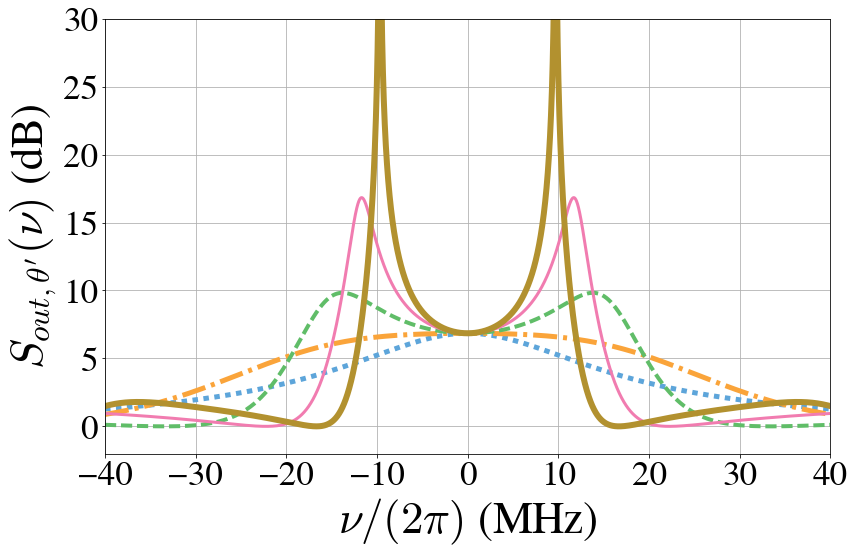

In [18]:
#Generates a plot for two-mode squeezing with feedback for different time-delays
%matplotlib inline

from pylab import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=25)
mpl.rc('ytick',labelsize=25)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['blue','orange','green','pink','brown']
plt.figure(3,figsize=(13,8))
fsfont = {'fontname':'FreeSerif'}

plt.hold(True)
plt.grid(True)
plt.xlabel('$\\nu/(2\pi)$ (MHz)',fontsize = 45,**fsfont)
plt.ylabel('$S_{out,\\theta^\\prime} (\\nu)$ (dB)',fontsize = 45,**fsfont)
plt.ylim(-2,30)
plt.xlim(-40,40)
plt.xticks(fontsize = 35,**fsfont)
plt.yticks(fontsize = 35,**fsfont)
ls = ["dotted","dashdot","dashed","solid","solid"]
lw = [5,5,4,3,6]
kt = np.linspace(0,1.8832785157443013,5)
nu = np.linspace(-40,40,50000)*2*np.pi
for i in range(0,5):
    #Sout_fb = Squeez(eps,theta,Del,kapa,ra,kta,phia,La+loss,thetapa,kapb,rb,ktb,phib,Lb+loss,thetapb,nu)    
    Sout_fb = Squeez(0.75*2*np.pi*10,0*np.pi,0,10*2.*pi,0.5,kt[i],0*np.pi,0,0,10*2.*pi,0.5,kt[i],0*np.pi,0,0,nu)
    print(kt[i])
    plt.plot(nu/2/pi,np.real(Sout_fb),color = colors[collab[i]],linewidth = lw[i],linestyle=ls[i])
plt.show()

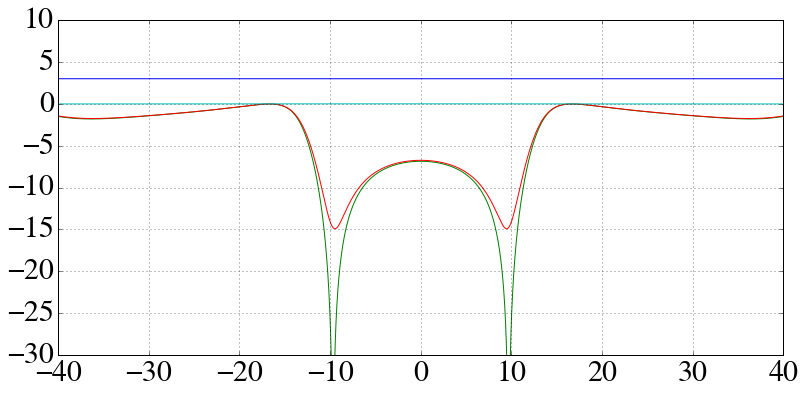

In [45]:
# OTHER RESULT IS NOT REPRODUCABLE DUE TO LACK OF PARAMETER VALUES
# Comparison of the two-mode squeezing spectra for the BS feedback and our coherent feedback
%matplotlib inline
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

#kappa is the same as eps for us, gam1, gam2 are kap1 and kap2 respectively.
#T is the transmissivity of the BS and L represents the losses in the feedback loop
#tau is the roundtrip time in the NOPA
gam1=0.05
T=0.72
gam2=0.000
L=0.00
tau=1.0
kap=0.75
def Zhou(kap,gam1,gam2,T,L,tau,Om):
    m=(-kap+gam1-gam2-1j*Om*tau)/(kap+gam1+gam2+1j*Om*tau)
    n=2*np.sqrt(gam1*gam2)/(kap+gam1+gam2+1j*Om*tau)
    first = m*T*np.sqrt(1-L)/(1-m*np.sqrt((1-T)*(1-L)))-np.sqrt(1-T)
    second = m*np.sqrt(T*L*(1-T)*(1-L))/(1-m*np.sqrt((1-T)*(1-L)))-np.sqrt(T*L)
    third = n*np.sqrt(T*(1-L))/(1-m*np.sqrt((1-T)*(1-L)))
    return 10*np.log10(np.real(2*(first**2+second**2+third**2)))
def nofb(eps,kap1a,kapa,Del,nu):
    N=int(len(nu))
    Sout_th  = np.zeros(N)
    Sout_th[int(N/2):N]  = 10*np.log10(1+4*eps*kap1a/((eps-kapa)**2+(nu[int(N/2):N]-Del)**2))    
    Sout_th[0:int(N/2)]  = 10*np.log10(1.+4*eps*kap1a/((eps-kapa)**2+(nu[0:int(N/2)]+Del)**2))
    return Sout_th

fig=plt.figure(1,figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
nu = np.linspace(-40,40,100000)*2*np.pi
ax.plot(nu/2/np.pi,Zhou(kap*10*2*np.pi,gam1,gam2,T,L,tau,nu))
ax.hold(True)
ax.grid(True)
#def Squeez(eps,theta,Del,kapa,ra,kta,phia,La,thetapa,kapb,rb,ktb,phib,Lb,thetapb,nu):
ax.plot(nu/2/np.pi,Squeez(kap*np.pi*10*2,np.pi,0,10*2*np.pi,0.5,1.8833,0,0,0,10*2*np.pi,0.5,1.8833,0,0,0,nu))
ax.plot(nu/2/np.pi,Squeez(kap*np.pi*10*2,np.pi,0,10*2*np.pi,0.5,1.8833,0,5,0,10*2*np.pi,0.5,1.8833,0,5,0,nu))
ax.plot(nu/2/np.pi,nofb(kap*10*2*np.pi,gam1,gam1+gam2,0,nu))
ax.set_ylim(-30,10)
plt.show()


In [4]:
#Generates a plot which determines the frequency of maximal two-mode squeezing with its value for different time-delays (3D)
%matplotlib inline
#%matplotlib notebook

from pylab import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy.interpolate import griddata
import mpl_toolkits.mplot3d as mp3d
import time

start=time.clock()

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['blue','orange','green','pink','brown']
fsfont = {'fontname':'FreeSerif'}

nu = np.linspace(0,60,10000)*2*np.pi
ta = np.linspace(0,4,400)
tb = np.linspace(0,4,400)
Smin = np.zeros((len(ta),len(tb)))
nus = np.zeros((len(ta),len(tb)))
tam,tbm = np.meshgrid(ta,tb)

for ia in range(0, len(ta)):
    for ib in range(0,len(tb)):
        Sout_fb = Squeez(0.75*2*np.pi*10,1*np.pi,0,10*2.*pi,0.5,ta[ia],0,0,0,10*2.*pi,0.5,tb[ib],0,0,0,nu)
        ind = np.argmin(Sout_fb)
        nus[ia,ib] = nu[ind]/2/np.pi
#        if np.min(Sout_fb)>=-40 and np.min(Sout_fb)<0:
        Smin[ia,ib]=np.min(Sout_fb)
#        else:
#            Smin[ia,ib]=-40

Lstartx = [0,4,4,0]
Lendx = [4,4,0,0]
Lstarty =[0,0,4,4]
Lendy=[0,4,4,0]

#Sminm = griddata((ta, tb), Smin, (ta[None,:], tb[:,None]), method='cubic')
fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax = fig.add_subplot(1, 1, 1)
p = ax.plot_surface(tam, tbm, nus, alpha=1.0,rstride=1, cstride=1, cmap=cm.RdYlGn, linewidth=0, antialiased=False)
#face2 = mp3d.art3d.Poly3DCollection([mid], alpha=0.3, linewidth=3)
#face2.set_facecolor((1, 1, 1, 0.3))
for i in range(4):
    ax.plot([Lstartx[i], Lendx[i]], [Lstarty[i],Lendy[i]],zs=[0,0],color="grey",lw=2)
#ax.add_collection3d(face2)
ax.set_zlim(-10,15)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))
levels = np.arange(-30.0, 0, 1.0)
#ax.invert_xaxis()
#ax.invert_yaxis()
ax.set_xticks([4., 3., 2., 1., 0.])
ax.set_yticks([4., 3., 2., 1., 0.])
ax.set_zticks([0., 5., 10., 15.])
#ax.view_init(elev=20., azim=-75)
ax.view_init(elev=20., azim=110)
cset = ax.contour(tam, tbm, Smin,levels=levels, zdir='z', offset=-10, cmap=cm.jet_r)
#cset = ax.contour(tam, tbm, Smin,levels=levels,  cmap=cm.RdYlGn)
cb = fig.colorbar(cset, shrink=0.6)
cb.ax.set_title('min$(S_{out}(\\nu_{m}))$\n', linespacing=1,**fsfont,fontsize=30)
ax.set_xlabel('\n$\kappa_a\\tau_a$',fontsize = 40,**fsfont,linespacing=1.5)
ax.set_ylabel('\n$\kappa_a\\tau_b$',fontsize = 40,**fsfont,linespacing=1.5)
#ax.zaxis.set_rotate_label(False)
ax.set_zlabel('\n$\\nu_{m}/2\pi$ (MHz)',fontsize = 40,**fsfont,linespacing=1.5, rotation=270)
#ax.xticks(fontsize = 35,**fsfont)
#ax.yticks(fontsize = 35,**fsfont)
plt.show()
end=time.clock()
durd=int((end-start)/60./60./24.)
durh=int((end-start)/60./60-24*durd)
durm=int((end-start)/60.-(24*durd+durh)*60.)
durs=int((end-start)-((24*durd+durh)*60+durm)*60)
print("Elapsed time: %d:%d:%d:%d" % (durd,durh,durm,durs))

NameError: name 'Squeez' is not defined

In [96]:
import time
start=time.clock()
end=time.clock()
end-start

8.799999977782136e-05

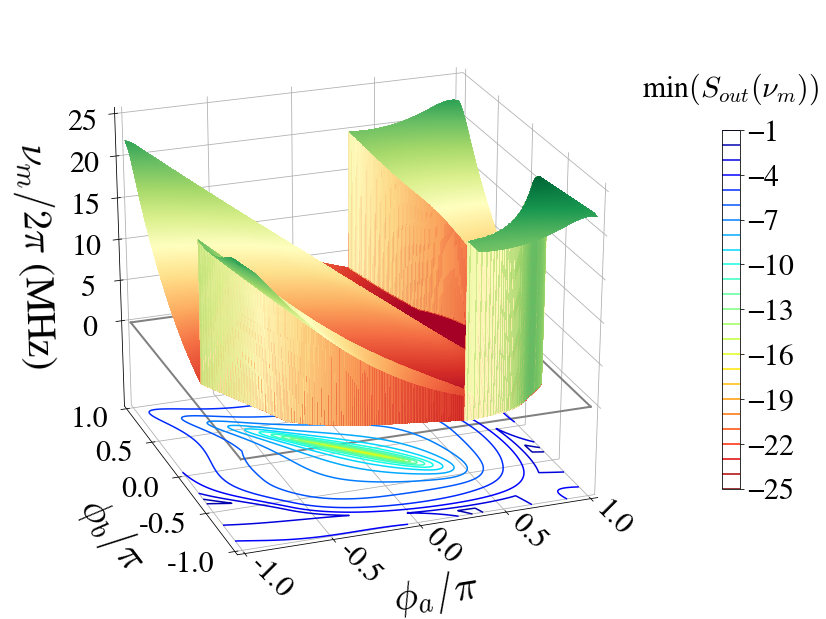

Elapsed time: 0:0:30:1


In [16]:
%matplotlib inline
#%matplotlib notebook

from pylab import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy.interpolate import griddata
import mpl_toolkits.mplot3d as mp3d
import time

start=time.clock()

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['blue','orange','green','pink','brown']
fsfont = {'fontname':'FreeSerif'}

ktaua=1.8832785157443013
ktaub=1.8832785157443013
nu = np.linspace(0,60,10000)*2*np.pi
pha = np.linspace(-1,1,600)*np.pi
phb = np.linspace(-1,1,600)*np.pi
Smin = np.zeros((len(pha),len(phb)))
nus = np.zeros((len(pha),len(phb)))
pham,phbm = np.meshgrid(pha/np.pi,phb/np.pi)

for ia in range(0, len(pha)):
    for ib in range(0,len(phb)):
        Sout_fb = Squeez(0.75*2*np.pi*10,1*np.pi,0,10*2.*pi,0.5,ktaua,pha[ia],0,0,10*2.*pi,0.5,ktaub,phb[ib],0,0,nu)
        ind = np.argmin(Sout_fb)
        nus[ia,ib] = nu[ind]/2/np.pi
#        if np.min(Sout_fb)>=-40 and np.min(Sout_fb)<0:
        Smin[ia,ib]=np.min(Sout_fb)
#        else:
#            Smin[ia,ib]=-40

Lstartx = [-1,1,1,-1]
Lendx = [1,1,-1,-1]
Lstarty =[-1,-1,1,1]
Lendy=[-1,1,1,-1]

#Sminm = griddata((ta, tb), Smin, (ta[None,:], tb[:,None]), method='cubic')
fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax = fig.add_subplot(1, 1, 1)
p = ax.plot_surface(pham, phbm, nus, alpha=0.7,rstride=1, cstride=1, cmap=cm.RdYlGn, linewidth=0, antialiased=False)
#face2 = mp3d.art3d.Poly3DCollection([mid], alpha=0.3, linewidth=3)
#face2.set_facecolor((1, 1, 1, 0.3))
for i in range(4):
    ax.plot([Lstartx[i], Lendx[i]], [Lstarty[i],Lendy[i]],zs=[0,0],color="grey",lw=2)
#ax.add_collection3d(face2)
ax.set_zlim(-10,25)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.tick_params(axis='x', which='major', pad=-10)
ax.tick_params(axis='y', which='major', pad=10)
ax.tick_params(axis='z', which='major', pad=15)
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))

labels=[-1., -0.5, 0., 0.5, 1.]
ax.set_yticklabels(labels,rotation=0,
                   verticalalignment='baseline',
                   horizontalalignment='right')
ax.set_zticks([0., 5., 10., 15.,20.,25.])
ax.set_xticklabels(labels,rotation=-45,
                   verticalalignment='top',
                   horizontalalignment='left')
levels = np.arange(-25.0, 0, 1.0)
#ax.invert_xaxis()
#ax.invert_yaxis()
#ax.view_init(elev=25., azim=-75)
ax.view_init(elev=25., azim=-110)
cset = ax.contour(pham, phbm, Smin,levels=levels, zdir='z', offset=-10.75, cmap=cm.jet_r)
#cset = ax.contour(tam, tbm, Smin,levels=levels,  cmap=cm.RdYlGn)
cb = fig.colorbar(cset, shrink=0.6)
cb.ax.set_title('min$(S_{out}(\\nu_{m}))$\n', linespacing=1,**fsfont,fontsize=30)
ax.set_xlabel('\n$\phi_a/\pi$',fontsize = 40,**fsfont,linespacing=2)
ax.set_ylabel('\n$\phi_b/\pi$',fontsize = 40,**fsfont,linespacing=3)
#ax.zaxis.set_rotate_label(False)
ax.set_zlabel('\n$\\nu_{m}/2\pi$ (MHz)',fontsize = 40,**fsfont,linespacing=3, rotation=270)
#ax.xticks(fontsize = 35,**fsfont)
#ax.yticks(fontsize = 35,**fsfont)
plt.show()
end=time.clock()
durd=int((end-start)/60./60./24.)
durh=int((end-start)/60./60-24*durd)
durm=int((end-start)/60.-(24*durd+durh)*60.)
durs=int((end-start)-((24*durd+durh)*60+durm)*60)
print("Elapsed time: %d:%d:%d:%d" % (durd,durh,durm,durs))

/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in double_scalars
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in exp
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in multiply
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in exp
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply
/h

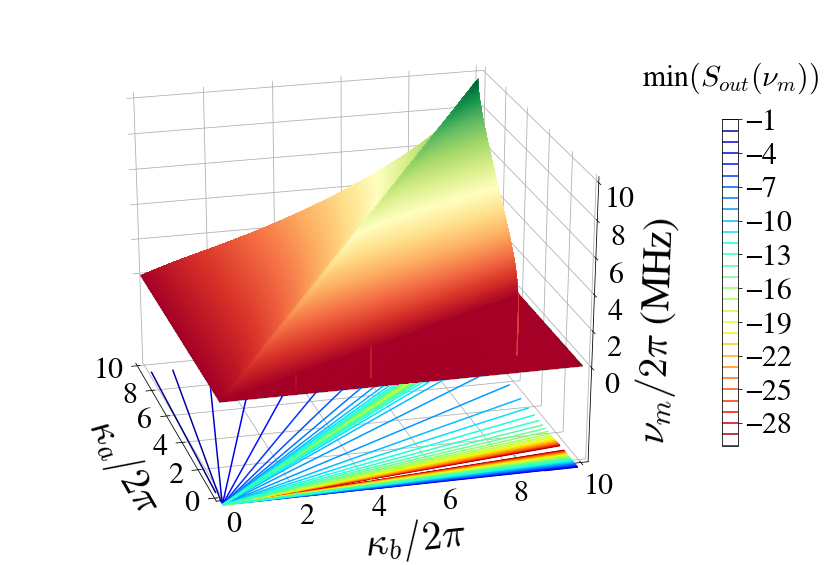

Elapsed time: 0:0:44:5


In [22]:
%matplotlib inline
#%matplotlib notebook

from pylab import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy.interpolate import griddata
import mpl_toolkits.mplot3d as mp3d
import time

start=time.clock()

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['blue','orange','green','pink','brown']
fsfont = {'fontname':'FreeSerif'}

ktaua=1.8832785157443013
ktaub=1.8832785157443013
nu = np.linspace(0,60,10000)*2*np.pi
kapa = np.linspace(0,10,600)*np.pi*2
kapb = np.linspace(0,10,600)*np.pi*2
Smin = np.zeros((len(kapa),len(kapb)))
nus = np.zeros((len(kapa),len(kapb)))
kapam,kapbm = np.meshgrid(kapa/2/np.pi,kapb/2/np.pi)

for ia in range(0, len(kapa)):
    for ib in range(0,len(kapb)):
        Sout_fb = Squeez(0.75*kapa[ia],1*np.pi,0,kapa[ia],0.5,ktaua,0,0,0,kapb[ib],0.5,ktaub,0,0,0,nu)
        ind = np.argmin(Sout_fb)
        nus[ia,ib] = nu[ind]/2/np.pi
#        if np.min(Sout_fb)>=-40 and np.min(Sout_fb)<0:
        Smin[ia,ib]=np.min(Sout_fb)
#        else:
#            Smin[ia,ib]=-40

Lstartx = [0,10,10,0]
Lendx = [10,10,0,0]
Lstarty =[0,0,10,10]
Lendy=[0,10,10,0]

#Sminm = griddata((ta, tb), Smin, (ta[None,:], tb[:,None]), method='cubic')
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax = fig.add_subplot(1, 1, 1)
p = ax.plot_surface(kapam, kapbm, nus, alpha=0.7,rstride=1, cstride=1, cmap=cm.RdYlGn, linewidth=0, antialiased=False)
#face2 = mp3d.art3d.Poly3DCollection([mid], alpha=0.3, linewidth=3)
#face2.set_facecolor((1, 1, 1, 0.3))
for i in range(4):
    ax.plot([Lstartx[i], Lendx[i]], [Lstarty[i],Lendy[i]],zs=[0,0],color="grey",lw=2)
#ax.add_collection3d(face2)
ax.set_zlim(-10,10)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.tick_params(axis='x', which='major', pad=5)
ax.tick_params(axis='y', which='major', pad=0)
ax.tick_params(axis='z', which='major', pad=5)
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))

labels=[0, 2, 4, 6, 8,10]
ax.set_yticklabels(labels,rotation=0,
                   verticalalignment='top',
                   horizontalalignment='left')
ax.set_zticks([0., 2.,4.,6.,8.,10])
ax.set_xticklabels(labels,rotation=0,
                   verticalalignment='baseline',
                   horizontalalignment='right')
levels = np.arange(-30.0,0, 1.0)
ax.invert_xaxis()
#ax.invert_yaxis()
ax.view_init(elev=25., azim=-15)
#ax.view_init(elev=30., azim=-110)
cset = ax.contour(kapam, kapbm, Smin,levels=levels, zdir='z', offset=-10.75, cmap=cm.jet_r)
#cset = ax.contour(tam, tbm, Smin,levels=levels,  cmap=cm.RdYlGn)
cb = fig.colorbar(cset, shrink=0.6)
cb.ax.set_title('min$(S_{out}(\\nu_{m}))$\n', linespacing=1,**fsfont,fontsize=30)
ax.set_xlabel('\n$\kappa_a/2\pi$',fontsize = 40,**fsfont,linespacing=1.5)
ax.set_ylabel('\n$\kappa_b/2\pi$',fontsize = 40,**fsfont,linespacing=1.5)
#ax.zaxis.set_rotate_label(False)
ax.set_zlabel('\n$\\nu_{m}/2\pi$ (MHz)',fontsize = 40,**fsfont,linespacing=1.5, rotation=270)
#ax.xticks(fontsize = 35,**fsfont)
#ax.yticks(fontsize = 35,**fsfont)
plt.show()
end=time.clock()
durd=int((end-start)/60./60./24.)
durh=int((end-start)/60./60-24*durd)
durm=int((end-start)/60.-(24*durd+durh)*60.)
durs=int((end-start)-((24*durd+durh)*60+durm)*60)
print("Elapsed time: %d:%d:%d:%d" % (durd,durh,durm,durs))